In [1]:
!nvidia-smi

Sun Apr 30 19:33:33 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:65:00.0 Off |                  N/A |
|  0%   45C    P2              144W / 390W|    825MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# (1) Import the necessary libraries

In [2]:
import glob
import pandas as pd
import tensorflow as tf
import numpy as np
import re
import time
import os
import tensorflow_hub as hub
from transformers import BertTokenizer, TFBertModel

2023-04-30 17:01:52.817634: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-30 17:01:52.855169: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# (2) Download the datasets

### You can download the datasets from https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset

In [80]:
!ls datasets/flickr30k_images

flickr30k_images  results.csv


# (3) Prepare the datasets

In [76]:
captioning_ds = pd.read_csv("datasets/flickr30k_images/results.csv", delimiter="|").sample(frac=1)

In [77]:
PERCENTAGE = int(captioning_ds.shape[0] * 0.8)
TOTAL_DATA = int(captioning_ds.shape[0])

In [78]:
train_data = captioning_ds.head(PERCENTAGE)
test_data = captioning_ds.tail(TOTAL_DATA - PERCENTAGE)

In [79]:
train_data.shape, test_data.shape, (train_data.shape[0] + test_data.shape[0]), TOTAL_DATA

((127132, 3), (31783, 3), 158915, 158915)

In [80]:
train_data.head(10)

,image_name,comment_number,comment
62881,3259228898.jpg,1,A man is kneeling in the top step while many ...
129716,499732144.jpg,1,a young boy in jeans and a blue shirt is wear...
81717,3681651647.jpg,2,People in red and black clothing are walking ...
13705,1916798494.jpg,0,A number of people are sitting in blue chairs...
148240,7007352148.jpg,0,A nicely dressed woman putting a handful of c...
87990,390899292.jpg,0,Two girls are conversing in front of some oth...
41990,2751466788.jpg,0,The man in the purple shirt is walking toward...
49462,2938181762.jpg,2,A person is walking near a fountain .
110740,468610158.jpg,0,A group of adults and children in scout unifo...
106082,4602993681.jpg,2,A black girl looking blankly with vases in th...


Use regex to remove some symbols and punctuation

In [82]:
def func(row):
    comment = str(row[2]).lower()
    comment = ' ' . join(re.findall(r"[a-z0-9]+", comment))
    comment = re.sub(r"\s", " ", comment) # replace any multiple spaces
    return {"image_name": row[0], "comment": comment}

In [83]:
train_cleaned = pd.DataFrame(dict(train_data.apply(func, axis=1))).transpose()
test_cleaned = pd.DataFrame(dict(test_data.apply(func, axis=1))).transpose()

In [85]:
train_cleaned.head(3)

,image_name,comment
62881,3259228898.jpg,a man is kneeling in the top step while many p...
129716,499732144.jpg,a young boy in jeans and a blue shirt is weari...
81717,3681651647.jpg,people in red and black clothing are walking i...


Create multigrams for all the comments

In [8]:
start_time = time.perf_counter()
print("Start processing ...")
complete_sets = []
for index, row in captionaing_cleaned.iterrows():
    comment_split = str("[CLS] " + row.comment + " [SEP]") . split() # Add special tokens to mark the beginning and end of the text
    for ind in range(1, len(comment_split)):
        complete_sets.append({
            "image_name": os.path.join("datasets/flickr30k_images/flickr30k_images", row.image_name), 
            "comment": ' ' . join(comment_split[:ind]),
            "target": comment_split[ind]
        })
end_time = time.perf_counter()
print(f"Processing time: {end_time - start_time} seconds")

Start processing ...
Processing time: 0.2571189273148775 seconds


In [9]:
complete_sets_pd = pd.DataFrame(complete_sets)

So for each image we need to create an n-grams that would probably be the next prediction words to the model

In [10]:
complete_sets_pd.head(10)

,image_name,comment,target
0,datasets/flickr30k_images/flickr30k_images/100...,[CLS],two
1,datasets/flickr30k_images/flickr30k_images/100...,[CLS] two,young
2,datasets/flickr30k_images/flickr30k_images/100...,[CLS] two young,guys
3,datasets/flickr30k_images/flickr30k_images/100...,[CLS] two young guys,with
4,datasets/flickr30k_images/flickr30k_images/100...,[CLS] two young guys with,shaggy
5,datasets/flickr30k_images/flickr30k_images/100...,[CLS] two young guys with shaggy,hair
6,datasets/flickr30k_images/flickr30k_images/100...,[CLS] two young guys with shaggy hair,look
7,datasets/flickr30k_images/flickr30k_images/100...,[CLS] two young guys with shaggy hair look,at
8,datasets/flickr30k_images/flickr30k_images/100...,[CLS] two young guys with shaggy hair look at,their
9,datasets/flickr30k_images/flickr30k_images/100...,[CLS] two young guys with shaggy hair look at ...,hands


# (4) Create text tokenizer and download the pretrained bertmodel for text preprocessing

Here i'll use the pretrained from bert model

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_model.trainable = False

2023-04-30 17:02:20.267330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21613 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6
2023-04-30 17:02:21.390720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a Bert

In [42]:
tokenizer.encode(captionaing_cleaned.comment[0])

[101,
 2048,
 2402,
 4364,
 2007,
 25741,
 2606,
 2298,
 2012,
 2037,
 2398,
 2096,
 5689,
 2041,
 1999,
 1996,
 4220,
 102]

In [10]:
tokenizer.convert_tokens_to_ids('[UNK]')

100

# (4) Create a data loader for our image

In [12]:
IMG_SIZE = [244, 244]

Find the longest available sequence in the datasets

In [48]:
MAX_SEQ_LEN = max([len(x.split()) for x in captionaing_cleaned.comment])
MAX_SEQ_LEN

49

The method i commend below doesn't support to return values with some custom shapes and data type

In [763]:
# def data_loader(image_path, comment, target): 
    
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_jpeg(image) 
#     image = tf.image.resize(image, IMG_SIZE)
#     image = tf.keras.applications.resnet.preprocess_input(image) # preprocess the image with resnet preprocessing
    
#     # Tokenize the text
#     comment = tokenizer.encode_plus(
#         comment.numpy().decode("utf-8"), 
#         max_length=MAX_SEQ_LEN, 
#         truncation=True, 
#         padding='max_length', 
#         add_special_tokens=True,
#         return_attention_mask=True, 
#         return_token_type_ids=False, 
#         return_tensors='tf'
#     )
     
#     caption_emb = bert_model(comment['input_ids'], comment['attention_mask'])[0]
#     target = tokenizer.encode(target.numpy().decode("utf-8"), add_special_tokens=False) # take the second index because first and last index will be the [CLS] and [SEP]
      
#     return (image, caption_emb), target # issues are here

In [745]:
# train = train_ds.map(lambda row: tf.py_function(
#     func=data_loader,
#     inp=[row[0], row[1], row[2]],
#     Tout=[(tf.float32, tf.float32), tf.int32]
# ), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

In [49]:
def data_generator(image_paths, comments, targets): 
    while True:
        for i in range(len(image_paths)):
            image = tf.io.read_file(image_paths[i])
            image = tf.image.decode_jpeg(image) 
            image = tf.image.resize(image, IMG_SIZE) 

            comment = tokenizer.encode_plus(
                comments[i].decode("utf-8"),
                max_length=MAX_SEQ_LEN,
                truncation=True,
                padding='max_length',
                add_special_tokens=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                return_tensors='tf'
            )
            caption_emb = bert_model(comment['input_ids'], comment['attention_mask'])[1]
            caption_emb = tf.squeeze(caption_emb, axis=0)

            target = tokenizer.encode(targets[i].decode("utf-8"), add_special_tokens=False)

            try: 
                if len(target) == 1: 
                    yield (image, caption_emb), target
                else:
                    # print(target, len(target))
                    yield (image, caption_emb), [target[0]] # to prevent the encoded target sometimes will generate 2 ids
            except:
                print(target, len(target))

In [50]:
tokenizer.encode("making", add_special_tokens=False)

[2437]

In [51]:
BATCH_SIZE = 4

In [54]:
train = tf.data.Dataset.from_generator(
    data_generator,
    args=[complete_sets_pd.image_name, complete_sets_pd.comment, complete_sets_pd.target],
    # output_types=((tf.float32, tf.float32), tf.int32), 
    output_signature=((tf.TensorSpec(shape=IMG_SIZE + [3], dtype=tf.float32), tf.TensorSpec(shape=(768), dtype=tf.float32)), tf.TensorSpec(shape=(1,), dtype=tf.int32))
).shuffle(buffer_size=100).prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE).cache()

Check the shape of our input data and target

In [56]:
# count = 0
# for x in train:
#     print("Input image shape: ", x[0].shape)
#     print("Bert output shape: ", x[1].shape) 
#     count += 1
 
#     if count == 1:
#         break

# (5) Build the models

In [57]:
def create_model():
    
    segmentation = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255.)
    ])
      
    inputs_img = tf.keras.layers.Input(shape=IMG_SIZE + [3])
    inputs_comment = tf.keras.layers.Input(shape=(768), dtype=tf.float32) # output shape from the pretrained bert model
 
    x_img = segmentation(inputs_img)
    x_img = tf.keras.layers.Conv2D(256, 3, activation="relu")(x_img)
    x_img = tf.keras.layers.MaxPooling2D(3)(x_img)
    x_img = tf.keras.layers.Conv2D(256, 3, activation="relu")(x_img)
    x_img = tf.keras.layers.MaxPooling2D(3)(x_img)
    x_img = tf.keras.layers.Dropout(.5)(x_img)
    x_img = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="valid")(x_img) 
    x_img = tf.keras.layers.Dense(256, activation="relu")(x_img)
    x_img = tf.keras.layers.GlobalAveragePooling2D()(x_img)
    x_img = tf.keras.layers.Dense(128, activation="relu")(x_img)
      
    # x_comment = tf.keras.layers.LSTM(128, activation="relu")(inputs_comment)
    x_comment = tf.keras.layers.Dense(128)(inputs_comment)
    x_img = tf.keras.layers.Dropout(.5)(x_img)
    x_comment = tf.keras.layers.Flatten()(x_comment)

    concat = tf.keras.layers.add([x_img, x_comment]) 
    concat = tf.keras.layers.BatchNormalization()(concat)
    
    concat = tf.keras.layers.Dense(128, activation="relu")(concat)
    outputs = tf.keras.layers.Dense(len(tokenizer.get_vocab()), activation="softmax")(concat)
    model = tf.keras.Model((inputs_img, inputs_comment), outputs)
    
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=["accuracy"])
    
    model.summary()
    
    return model

In [58]:
model = create_model()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_6 (Sequential)      (None, 244, 244, 3)  0           ['input_16[0][0]']               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 242, 242, 25  7168        ['sequential_6[0][0]']           
                                6)                                                                
                                                                                            

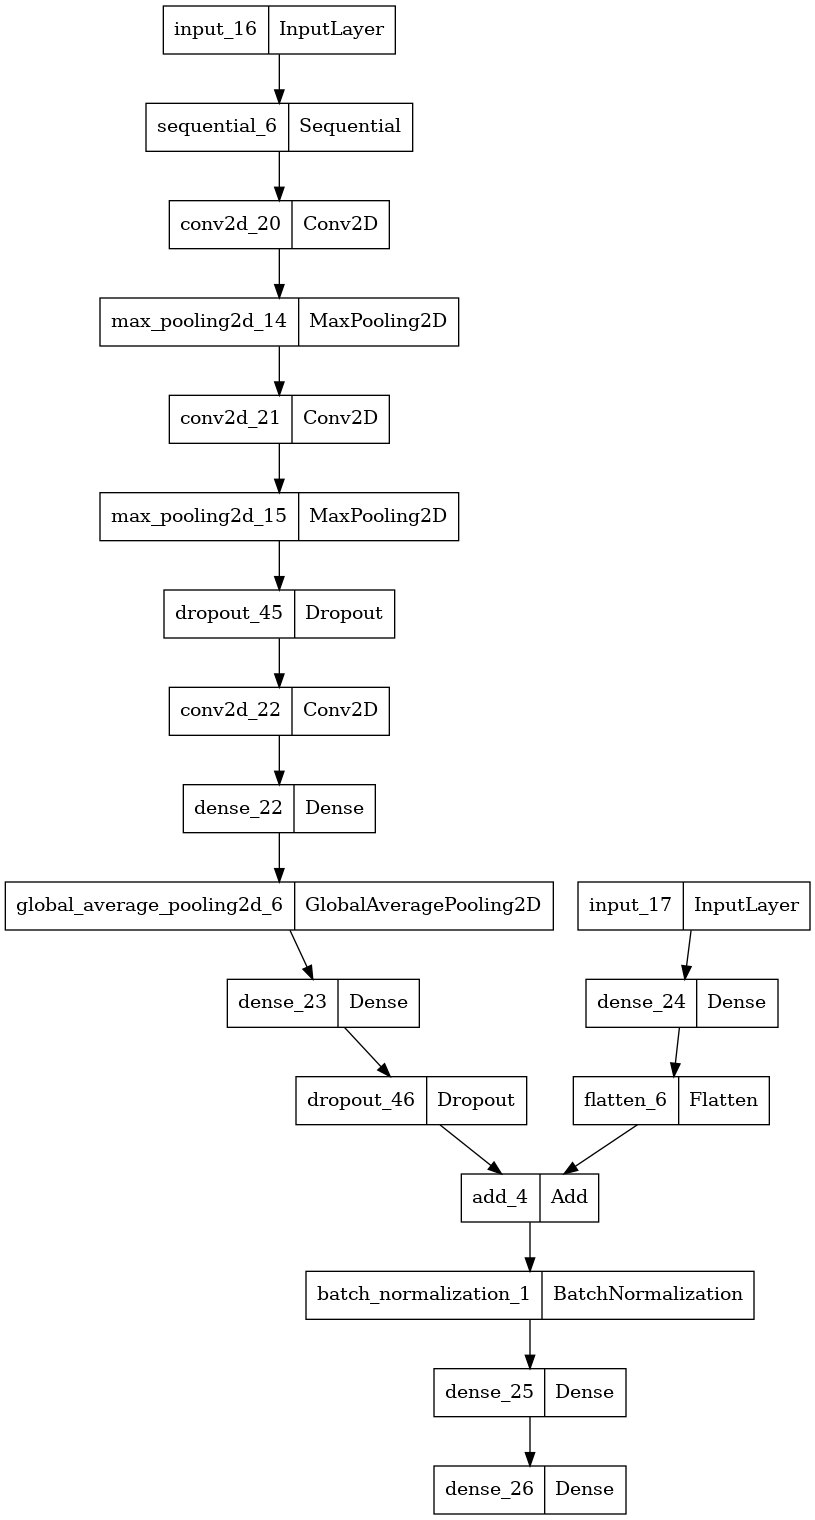

In [59]:
tf.keras.utils.plot_model(model)

# (6) Prepare for training

In [60]:
class ModelCheckpointCustom(tf.keras.callbacks.Callback):
    
    def __init__(self, model_path, save_best_only=False):
        super(ModelCheckpointCustom, self).__init__()
         
        self.model_path = model_path
        self.save_best_only = save_best_only
        self.best_val_loss = float('inf') 

    def on_epoch_end(self, epoch, logs=None):
        
        print('\rlogs: ', logs, '\r')
        
        current_val_loss = 0 if logs['loss'] is None else logs['loss']
        
        print('\rcurrent_val_loss: ', current_val_loss, '\r')
        print('\rsave_best_only: ', self.save_best_only, '\r')
        print('\rbest_val_loss: ', self.best_val_loss, '\r')
        print('\rcurrent_val_loss < best_val_loss: ', current_val_loss < self.best_val_loss, '\r') 
        
        if self.save_best_only and current_val_loss < self.best_val_loss:
            print('\rSaving weights at (save_best_only=True): ', self.model_path, '\r')
            self.best_val_loss = current_val_loss 
            self.model.save_weights(self.model_path)
            print("\rModel has been saved!")
        else:
            print('\rSaving weights at (save_best_only=False): ', self.model_path, '\r')
            self.model.save_weights(self.model_path) 
            print("\rModel has been saved!")

save_callbacks = ModelCheckpointCustom(model_path='checkpoint/save-model/', save_best_only=True)

In [61]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=7, start_from_epoch=0)

# (7) Train the models

In [62]:
# model.load_weights("model.weights.h5")

In [63]:
history = model.fit(train, epochs=200, steps_per_epoch=1000, callbacks=[save_callbacks, early_stop])

Epoch 1/200


2023-04-30 18:17:07.034352: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_45/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-30 18:17:17.231029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 80 of 100
2023-04-30 18:17:19.722803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


 152/1000 [===>..........................] - ETA: 7:40 - loss: 9.9836 - accuracy: 0.1053

2023-04-30 18:18:44.001741: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
Exception ignored in: <generator object data_generator at 0x7f5ee8368740>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 875, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
RuntimeError: generator ignored GeneratorExit


[3899] 1
[2007] 1


Exception ignored in: <generator object data_generator at 0x7f65901984a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 875, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
RuntimeError: generator ignored GeneratorExit


logs:  {'loss': 7.476396083831787, 'accuracy': 0.14499999582767487} - accuracy: 0.1450
current_val_loss:  7.476396083831787 
save_best_only:  True 
best_val_loss:  inf 
current_val_loss < best_val_loss:  True 
Saving weights at (save_best_only=True):  checkpoint/save-model/ 
Model has been saved!
1000/1000 [==============================] - 560s 545ms/step - loss: 7.4764 - accuracy: 0.1450
Epoch 2/200
logs:  {'loss': 6.104391574859619, 'accuracy': 0.15825000405311584} - accuracy: 0.1583
current_val_loss:  6.104391574859619 
save_best_only:  True 
best_val_loss:  7.476396083831787 
current_val_loss < best_val_loss:  True 
Saving weights at (save_best_only=True):  checkpoint/save-model/ 
Model has been saved!
1000/1000 [==============================] - 547s 548ms/step - loss: 6.1044 - accuracy: 0.1583
Epoch 3/200
logs:  {'loss': 5.890750408172607, 'accuracy': 0.17225000262260437} - accuracy: 0.1723
current_val_loss:  5.890750408172607 
save_best_only:  True 
best_val_loss:  6.1043915748

KeyboardInterrupt: 

In [996]:
model.save_weights("model.weights.h5")

In [ ]:
!du -h -a --max-depth=1